<a href="https://colab.research.google.com/github/mathgurgel/Artificial_Intelligence/blob/main/searching-algorithms/homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation, rc
from math import sqrt
from queue import PriorityQueue

# Classe Labirinto


In [2]:
class Labirinto:
  
  def __init__(self,dim=10):
    
    # Inicializando o labirinto. Nele, vamos considerar que todas as celulas sao paredes
    self.labirintoPlot    =  np.zeros((dim,dim,3), dtype=np.int64)
    self.labirintoArestas =  np.zeros((dim,dim), dtype=np.int64)
    self.labirintoMatriz  = [[i+j for i in range(10)] for j in range(0, 100, 10)]
    self.dim = dim 

    # Selecionar uma celula parede do labirinto como ponto inicial. Com a selecao abaixo,
    # o labirinto sempre tera seu inicio no canto esquerdo do grafico
    posicaoInicial = np.random.randint(0, (dim-1))
    

    fronteira = []
    fronteira.append((posicaoInicial,0))
    dx = [ 0, 1, 0, -1] # Movimentacao de x
    dy = [-1, 0, 1,  0] # movimentacao de y

    while fronteira != []:
      # Transformar a celula (parede) do labirinto em uma celula valida
      (vx, vy) = fronteira[-1] # Selecionando o ultimo elemento da lista
      self.labirintoArestas[vx,vy] = 1
      
      # verificar se a celula (parede) possui somente um vizinho que nao seja parede
      # caso sim, podemos incluir ela como uma passagem.
      vizinhosNaoVisitados=[]

      # Consideramos que a celula tem vizinhos acima, abaixo a esquerda e a direita.
      # Para isso, utilizamos as listas dx e dy para determinar essas posicoes
      for i in range(4):
        nx = vx + dx[i]
        ny = vy + dy[i]

        if nx >=0 and nx < dim and ny >=0 and ny < dim:
          if self.labirintoArestas[nx, ny] == 0:
            
            confereVizinho=0
            for j in range(4):
              ex = nx + dx[j]
              ey = ny + dy[j]

              if ex >=0 and ex < dim and ey >=0 and ey < dim:
                if self.labirintoArestas[ex, ey] == 1:
                  confereVizinho +=1
            
            if confereVizinho == 1:
              vizinhosNaoVisitados.append(i)
      
      if len(vizinhosNaoVisitados) > 0:
        irPara= np.random.choice(vizinhosNaoVisitados)
        vx += dx[irPara]
        vy += dy[irPara]
        fronteira.append((vx,vy))
      else:
        fronteira.pop()
    
    # Ajustar a posicao final (considerando um ponto do lado direito do labirinto)
    encontrou= False
    while not encontrou:
      posicaoFinal = np.random.randint(0,(dim-1))
      if self.labirintoArestas[posicaoFinal, dim-1] ==1:
        encontrou=True
    

    # Colorir Labirinto
    self.labirintoPlot[:,:, 0] += 255* self.labirintoArestas
    self.labirintoPlot[:,:, 1] += 255* self.labirintoArestas
    self.labirintoPlot[:,:, 2] += 255* self.labirintoArestas

    # Colorir posicao inicial e final
    self.labirintoPlot[posicaoInicial,0,1] = 0
    self.labirintoPlot[posicaoInicial,0,2] = 0

    self.labirintoPlot[posicaoFinal,dim-1, 0] = 0
    self.labirintoPlot[posicaoFinal,dim-1, 1] = 0

    # Armazenar no objeto as posicoes inicial e final do labirinto
    self.posicaoInicial = (posicaoInicial,0)
    self.posicaoFinal = (posicaoFinal,dim-1)

  def getLabirintoPlot(self, posicoes=None, cores=(255,0,0)):
    if posicoes==None:
      return self.labirintoPlot

    resposta = self.labirintoPlot.copy()
    for t in posicoes:
      for camada in range(3):
        resposta[t[0],t[1],camada] = cores[camada]
    
    return resposta
  
  def getPosicaoInicio(self):
    return self.posicaoInicial

  def getDestino(self):
    return self.posicaoFinal

  def getLabirintoArestas(self):
    return self.labirintoArestas

# Funções auxiliares. Serão utilizadas para exibição dos nós visitados no labirinto

In [13]:
def converte_pos(celula):

  (x, y) = celula

  '''
  [[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
   [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
   [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
   [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
   [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
   [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
   [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
   [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
   [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
   [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]
  '''

  return (x * 10 + y)


def get_vizinhos(celula, limite, labirinto):
  
  (x, y) = celula

  mtx = labirinto.getLabirintoArestas()

  viz_esq = (x, y - 1) if y > 0      and mtx[x, y - 1] else None
  viz_dir = (x, y + 1) if y < limite and mtx[x, y + 1] else None
  viz_inf = (x + 1, y) if x < limite and mtx[x + 1, y] else None
  viz_sup = (x - 1, y) if x > 0      and mtx[x - 1, y] else None

  vizinhos = []
  if viz_esq: vizinhos.append(viz_esq)
  if viz_dir: vizinhos.append(viz_dir)
  if viz_inf: vizinhos.append(viz_inf)
  if viz_sup: vizinhos.append(viz_sup)

  return vizinhos


def selecionaCaminho(caminhos, destino):

  caminho = []
  celula = destino
  while celula != None:
    caminho.insert(0, celula)
    celula = caminhos[converte_pos(celula)]
  
  print(caminho)
  return caminho


def euclidean_distance(coord1, coord2):

  (x1, y1) = coord1
  (x2, y2) = coord2

  return sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)


def convert_pq_to_queue(priority_q):

  queue = []

  for (_, data) in priority_q.queue:
    queue.append(data)
  
  return queue

# Definição dos algoritmos de busca



## Busca em largura

In [ ]:
def buscaEmLargura(labirinto):

  fronteira = [] # lista vazia
  caminhos = [None for x in range(100)]
  celulasVisitadas = []
  statusLabirinto = []

  fronteira.append(labirinto.getPosicaoInicio())

  while fronteira != []:
    # Imprime Fronteira
    statusLabirinto.append(labirinto.getLabirintoPlot(posicoes=fronteira, cores=(0,255,127)))

    celula = fronteira.pop(0) # Selecionando o primeiro elemento da lista
    celulasVisitadas.append(celula)
    
    if celula == labirinto.getDestino():
      print("Objetivo", celula, "encontrado")
      caminhoEncontrado = selecionaCaminho(caminhos, labirinto.getDestino())## Guia para implementar
      statusLabirinto.append(labirinto.getLabirintoPlot(posicoes=caminhoEncontrado, cores=(0,0,255)))
      return statusLabirinto
    
    else:
      for vizinho in get_vizinhos(celula, 10 - 1, labirinto):
        if vizinho not in celulasVisitadas:
          fronteira.append(vizinho)
          caminhos[converte_pos(vizinho)] = celula
  
  print("Objetivo nao existente no grafo")

## Busca em profundidade

In [ ]:
def buscaEmProfundidade(labirinto):

  fronteira = [] # lista vazia
  caminhos = [None for x in range(100)]
  celulasVisitadas = []
  statusLabirinto = []

  fronteira.append(labirinto.getPosicaoInicio())

  while fronteira != []:
    # Imprime Fronteira
    statusLabirinto.append(labirinto.getLabirintoPlot(posicoes=fronteira, cores=(0,255,127)))

    celula = fronteira.pop() # Selecionando o ultimo elemento da lista
    celulasVisitadas.append(celula)
    
    if celula == labirinto.getDestino():
      print("Objetivo", celula, "encontrado")
      caminhoEncontrado = selecionaCaminho(caminhos, labirinto.getDestino())## Guia para implementar
      statusLabirinto.append(labirinto.getLabirintoPlot(posicoes=caminhoEncontrado, cores=(0,0,255)))
      return statusLabirinto
    
    else:
      for vizinho in get_vizinhos(celula, 10 - 1, labirinto):
        if vizinho not in celulasVisitadas:
          fronteira.append(vizinho)
          caminhos[converte_pos(vizinho)] = celula
  
  print("Objetivo nao existente no grafo")

##Best first

In [14]:
# Adapted from https://www.geeksforgeeks.org/best-first-search-informed-search/

def best_first_search(maze):

  mtx = maze.getLabirintoArestas()
  actual_src = maze.getPosicaoInicio()
  target = maze.getDestino()
  n = 100
  maze_status = []
  predecessors = [None] * 100

  costs = [euclidean_distance((x, y), target) for x in range(10) for y in range(10)]

  visited = [False] * n
  pq = PriorityQueue()
  pq.put((0, actual_src))
  visited[converte_pos(actual_src)] = True
  
  # pq : costs

  # 00 01 02 03 04 
  # 10 11 12 13 14
  # 20 21 22 23 24
  # 30 31 32 33 34

  # (0, 0) (3, 4)


  while not pq.empty():

    maze_status.append(maze.getLabirintoPlot(posicoes=convert_pq_to_queue(pq), cores=(0,255,127)))
    
    current_element = pq.get()[1]

    # Displaying the path having lowest cost
    print(current_element, end=" ")
    if current_element == target:
      print("Objetivo", current_element, "encontrado")
      path_found = selecionaCaminho(predecessors, maze.getDestino())
      maze_status.append(maze.getLabirintoPlot(posicoes=path_found, cores=(0,0,255)))
      return maze_status

    for neighbor in get_vizinhos(current_element, 10 - 1, maze):
      ngb_pos = converte_pos(neighbor)
      if visited[ngb_pos] == False:
        visited[ngb_pos] = True
        pq.put((costs[ngb_pos], neighbor))
        predecessors[ngb_pos] = current_element

## A*

In [15]:
def a_star_search(maze):

  mtx = maze.getLabirintoArestas()
  actual_src = maze.getPosicaoInicio()
  target = maze.getDestino()
  n = 100
  maze_status = []
  predecessors = [None] * 100

  heuristic = [euclidean_distance((x, y), target) for x in range(10) for y in range(10)]
  costs = [1] * 100

  visited = [False] * n
  pq = PriorityQueue()
  pq.put((0, actual_src))
  visited[converte_pos(actual_src)] = True

  while not pq.empty():

    maze_status.append(maze.getLabirintoPlot(posicoes=convert_pq_to_queue(pq), cores=(0,255,127)))
    
    current_element = pq.get()[1]

    # Displaying the path having lowest cost
    print(current_element, end=" ")
    if current_element == target:
      print("Objetivo", current_element, "encontrado")
      path_found = selecionaCaminho(predecessors, maze.getDestino())
      maze_status.append(maze.getLabirintoPlot(posicoes=path_found, cores=(0,0,255)))
      return maze_status

    for neighbor in get_vizinhos(current_element, 10 - 1, maze):
      ngb_pos = converte_pos(neighbor)
      if visited[ngb_pos] == False:
        visited[ngb_pos] = True
        final_cost = heuristic[ngb_pos] + costs[ngb_pos] # A* f(p)
        pq.put((final_cost, neighbor))
        predecessors[ngb_pos] = current_element

# Execução dos algoritmos de busca

## Criação do objeto labirinto (Escolha do tamanho e exibição do labirinto)

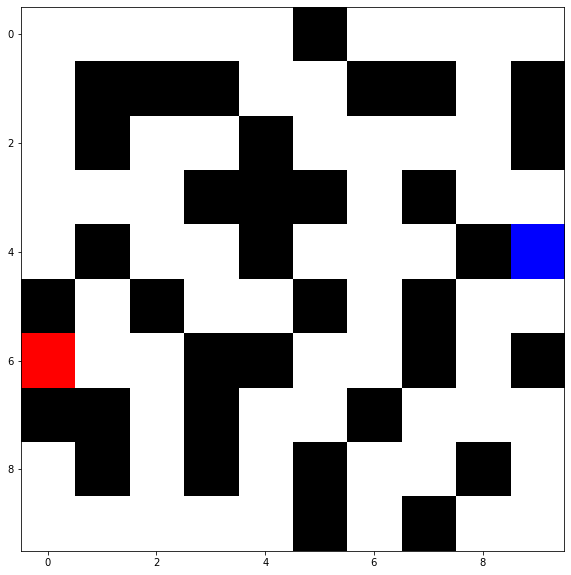

In [5]:
# Podemos construir labirintos com diversas dimensoes (a ciratividade eh sua!)
labirinto = Labirinto(10) # Voces podem alterar a dimensao do labirinto (testei ate o tamanho 30). Caso aumente muito, vai ficar dificil de visualizar o resultado

fig = plt.figure(figsize=(10,10))
plt.imshow(labirinto.getLabirintoPlot())

## Busca em Largura

In [ ]:
snapshots = buscaEmLargura(labirinto)


Objetivo (7, 9) encontrado
[(2, 0), (2, 1), (1, 1), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 6), (2, 6), (2, 5), (3, 5), (3, 4), (3, 3), (3, 2), (4, 2), (4, 1), (4, 0), (5, 0), (6, 0), (7, 0), (7, 1), (7, 2), (8, 2), (9, 2), (9, 3), (9, 4), (8, 4), (8, 5), (7, 5), (6, 5), (6, 6), (6, 7), (5, 7), (4, 7), (4, 8), (4, 9), (5, 9), (6, 9), (7, 9)]


## Busca em profundidade

In [ ]:
snapshots = buscaEmProfundidade(labirinto)

Objetivo (7, 9) encontrado
[(2, 0), (2, 1), (1, 1), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 6), (2, 6), (2, 5), (3, 5), (3, 4), (3, 3), (3, 2), (4, 2), (4, 1), (4, 0), (5, 0), (6, 0), (7, 0), (7, 1), (7, 2), (8, 2), (9, 2), (9, 3), (9, 4), (8, 4), (8, 5), (7, 5), (6, 5), (6, 6), (6, 7), (5, 7), (4, 7), (4, 8), (4, 9), (5, 9), (6, 9), (7, 9)]


##Best first

In [18]:
snapshots = best_first_search(labirinto)

(6, 0) (6, 1) (6, 2) (7, 2) (5, 1) (8, 2) (9, 2) (9, 3) (9, 4) (8, 4) (7, 4) (7, 5) (6, 5) (6, 6) (5, 6) (4, 6) (4, 7) (3, 6) (2, 6) (2, 7) (2, 8) (3, 8) (3, 9) (4, 9) Objetivo (4, 9) encontrado
[(6, 0), (6, 1), (6, 2), (7, 2), (8, 2), (9, 2), (9, 3), (9, 4), (8, 4), (7, 4), (7, 5), (6, 5), (6, 6), (5, 6), (4, 6), (3, 6), (2, 6), (2, 7), (2, 8), (3, 8), (3, 9), (4, 9)]


## A*


In [16]:
snapshots = a_star_search(labirinto)

(6, 0) (6, 1) (6, 2) (7, 2) (5, 1) (8, 2) (9, 2) (9, 3) (9, 4) (8, 4) (7, 4) (7, 5) (6, 5) (6, 6) (5, 6) (4, 6) (4, 7) (3, 6) (2, 6) (2, 7) (2, 8) (3, 8) (3, 9) (4, 9) Objetivo (4, 9) encontrado
[(6, 0), (6, 1), (6, 2), (7, 2), (8, 2), (9, 2), (9, 3), (9, 4), (8, 4), (7, 4), (7, 5), (6, 5), (6, 6), (5, 6), (4, 6), (3, 6), (2, 6), (2, 7), (2, 8), (3, 8), (3, 9), (4, 9)]


# Animando o labirinto
Podemos utilizar os labirintos retornados pelo algoritmo de busca para poder visualizar cada uma das iterações do algoritmo. No momento da busca, estão registrados tanto as fronteiras do algoritmo de busca quanto o resultado final encontrado. 

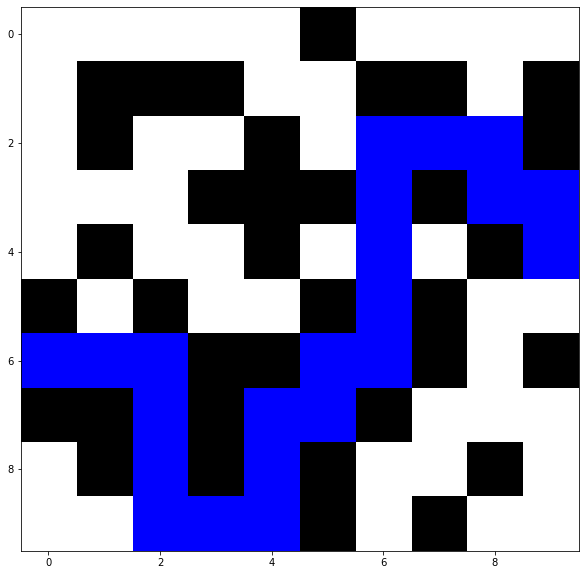

In [17]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(10,10))

# initialization function: plot the background of each frame
def init():
  a = labirinto.getLabirintoPlot()
  im = plt.imshow(a, interpolation='none', aspect='auto', vmin=0, vmax=1)
  return [im]


def animate_func(i):
  im = plt.imshow(snapshots[i], interpolation='none', aspect='auto', vmin=0, vmax=1)
  #im.set_array(snapshots[i])
  return [im]

anim = animation.FuncAnimation(fig,
                               animate_func,
                               init_func=init,
                               frames=len(snapshots), # Numero de frames para animacao
                               interval=100, # Intervalo entre cada frame (em milisegundos)
                               blit=True)
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim